### And welcome to Week 4, Day 3 - more LangGraph..

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

"Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world's most important and ... Paris , the capital and largest city of France, is located in the northern part of the country on the banks of the Seine River . Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... The capital of France has been Paris since its liberation in 1944. Paris is the ca

### Now here is a LangChain wrapper class for converting functions into Tools

In [4]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )



### Now we can try out the tool the langchain way

In [5]:
tool_search.invoke("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris, the capital city of France, is often referred to as the “City of Light” (La Ville Lumière) due to its role as a center of enlightenment ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris is the city of romance par 

### And now let's write a tool ourselves

We'll pick a familiar one

In [6]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [7]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

In [15]:
from langchain.tools import StructuredTool
from pydantic import BaseModel, Field


class SendEmailInput(BaseModel):
    to_email: str = Field(description="Recipient email address")
    subject: str = Field(description="Email subject")
    body: str = Field(description="Email body")

def send_email(to_email, subject, body):
    from_email = os.getenv("GMAIL_EMAIL")
    password = os.getenv("GMAIL_APP_PASSWORD")

    if not password:
        print("❌ Error: GMAIL_APP_PASSWORD not found in environment variables")
        return

    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login(from_email, password)
            server.send_message(msg)
            print("✅ Email sent successfully!")
    except Exception as e:
        print(f"❌ Error sending email: {e}")


# Test sending to yourself
# send_email(os.getenv("GMAIL_EMAIL"), "Test Subject", "Hello from Python!")

tool_send_email = StructuredTool.from_function(
    func=send_email,
    name="send_email",
    description="Send an email to a recipient",
    args_schema=SendEmailInput
)

tool_send_email.invoke({
    "to_email": os.getenv("GMAIL_EMAIL"),
    "subject": "Test Subject",
    "body": "Hello from Python!"
})

✅ Email sent successfully!


In [6]:
def send_email(subjectAndBody: str):
    """Send an email to the user"""
    from_email = os.getenv("GMAIL_EMAIL")
    password = os.getenv("GMAIL_APP_PASSWORD")
    to_email = os.getenv("GMAIL_EMAIL")

    if not password:
        print("❌ Error: GMAIL_APP_PASSWORD not found in environment variables")
        return

    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subjectAndBody
    msg.attach(MIMEText(subjectAndBody, 'plain'))

    try:
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login(from_email, password)
            server.send_message(msg)
            print("✅ Email sent successfully!")
    except Exception as e:
        print(f"❌ Error sending email: {e}")


# Test sending to yourself
# send_email(os.getenv("GMAIL_EMAIL"), "Test Subject", "Hello from Python!")

tool_send_email = Tool(
    func=send_email,
    name="send_email",
    description="Useful when you want to send an email",
)

tool_send_email.invoke("this is a test email")

✅ Email sent successfully!


### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [7]:
# tools = [tool_search, tool_push]
tools = [tool_search, tool_send_email]

In [8]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [10]:
# This is different:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [11]:
# Step 3: Create a Node


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [12]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

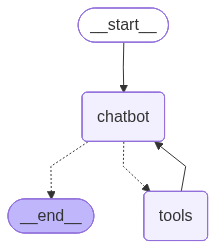

In [13]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [14]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


✅ Email sent successfully!


## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

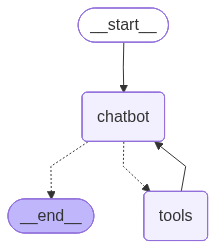

In [15]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='05fce9cd-23d9-4e8f-a2cc-300926535e99'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 87, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CX9mUMYCCY5OaQQ6UHIcLPUs2PW6u', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ad8f933f-b1f4-4e5f-b85b-b0045ba5b14f-0', usage_metadata={'input_tokens': 87, 'output_tokens': 10, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='my name 

In [17]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='05fce9cd-23d9-4e8f-a2cc-300926535e99'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 87, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CX9mUMYCCY5OaQQ6UHIcLPUs2PW6u', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ad8f933f-b1f4-4e5f-b85b-b0045ba5b14f-0', usage_metadata={'input_tokens': 87, 'output_tokens': 10, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMess

In [20]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='05fce9cd-23d9-4e8f-a2cc-300926535e99'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 87, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CX9mUMYCCY5OaQQ6UHIcLPUs2PW6u', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ad8f933f-b1f4-4e5f-b85b-b0045ba5b14f-0', usage_metadata={'input_tokens': 87, 'output_tokens': 10, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMes

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [21]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

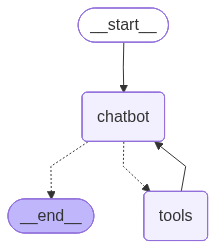

In [22]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [ ]:
config = {"configurable": {"thread_id": "4"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='c2055209-5a7f-4df2-992a-eb6081fd6fc0')]}
{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='c2055209-5a7f-4df2-992a-eb6081fd6fc0'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 87, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CXB7jC1TUfeCwNkJasSqBcOJD99jY', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c70af710-26a4-4b5c-89a6-a53862f57a07-0', usage_metadata={'input_tokens': 87, 'output_tokens': 10, 'total_tokens': 97, 'inp